# Smoothed-gridded seismicity of the Indian Subcontinent

This is an attempt to reproduce the results of Nath & Thingbaijam (2012) since their electronic supplement is in error.

In [90]:
%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
import os
from copy import deepcopy
from StringIO import StringIO
from IPython.display import display

import numpy as np
import pandas as pd
import lxml.etree as et
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import toolbox as tb
%autoreload 2
import source_model_tools as smt

from openquake.hazardlib import tom, geo
import hmtk.sources as src
%autoreload 2
import hmtk.plotting.seismicity.catalogue_plots as scp

from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.plotting.mapping import HMTKBaseMap
%autoreload 2
from hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity
%autoreload 2
from hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian

from hmtk.seismicity.selector import CatalogueSelector
from hmtk.seismicity.declusterer.dec_afteran import Afteran 
from hmtk.seismicity.declusterer.dec_gardner_knopoff import GardnerKnopoffType1 
from hmtk.seismicity.declusterer.distance_time_windows import (GardnerKnopoffWindow, 
                                                               GruenthalWindow, 
                                                               UhrhammerWindow)

import scipy.stats as scs
import poisson_test

In [92]:
# define some lists needed at different stages
layer_ids = [1, 2, 3, 4]
layer_depths_km = [0, 25, 70, 180, 300]

df_layers = pd.DataFrame(zip(layer_ids, layer_depths_km[:-1], layer_depths_km[1:]), columns=['id','zmin','zmax'])
display(df_layers)

min_mags = [4.5, 5.5]
corr_dists_km = [65, 85]

df_models = pd.DataFrame(zip(min_mags, corr_dists_km), columns=['min mag','corr dist'])
display(df_models)

,id,zmin,zmax
0,1,0,25
1,2,25,70
2,3,70,180
3,4,180,300


,min mag,corr dist
0,4.5,65
1,5.5,85


In [93]:
# define some input and output filenames
catalogue_txt = '../Catalogue/SACAT1900_2008v2.txt'
catalogue_csv = catalogue_txt.replace('.txt','.csv')
completeness_csv = '../Data/thingbaijam2011seismogenic/Table1.csv'

model_path = '../Data/nath2012probabilistic'
old_txt_template = os.path.join(model_path,'lay%dsmooth%.1f.txt')
recomputed_path = './Recomputed'
large_csv_template = os.path.join(recomputed_path, 'smoothed_seismicity_layer%d_mmin%g.csv')
small_csv_template = os.path.join(recomputed_path, 'smoothed_source_model_mmin_%g_layer_%d.csv')
new_txt_template = os.path.join(recomputed_path, os.path.split(old_txt_template)[1])

In [94]:
# read completeness table
completeness_df = pd.read_csv(completeness_csv, header=[0,1], index_col=[0,1])
completeness_tables = [[[[completeness_df.loc[z_min, z_max][str(mag), 'start'], mag]]
                        for mag in min_mags] 
                       for z_min, z_max in zip(layer_depths_km[:-1], layer_depths_km[1:])]
completeness_df.columns = [' '.join(col).strip() for col in completeness_df.columns.values]
completeness_df.reset_index(inplace=True)
df_layers = pd.merge(completeness_df, df_layers)
df_layers

,zmin,zmax,4 start,4 end,4.5 start,4.5 end,5.5 start,5.5 end,id
0,0,25,1994,2008,1964,2008,1903,2008,1
1,25,70,1990,2008,1964,2008,1902,2008,2
2,70,180,1996,2008,1964,2008,1914,2008,3
3,180,300,1970,2008,1984,2008,1912,2008,4


In [95]:
# reformat the catalogue and write it to CSV
catalogue_reformat_df = pd.read_csv(catalogue_txt, sep='\t')
catalogue_reformat_df.columns = [item.lower() for item in catalogue_reformat_df.columns]
catalogue_reformat_df['eventID'] = catalogue_reformat_df.index.values
RENAME_COLS = {
    'source': 'Agency',
    'lat': 'latitude',
    'lon': 'longitude',
    'hh': 'hour',
    'mm': 'minute',
    'ss': 'second',
    'mag_mw': 'magnitude',
    'mag_mw_err': 'sigmaMagnitude',
    'depth_err': 'depthError',
    'shock_type': 'comment',
}
catalogue_reformat_df.rename(columns=RENAME_COLS, inplace=True)
catalogue_reformat_df.to_csv(catalogue_csv, index=False)

In [111]:
# parse the CSV catalogue
parser = CsvCatalogueParser(catalogue_csv) 
catalogue = parser.read_file() 

print 'Number of entries:', len(catalogue.data['eventID'])
print 'Keys before cleaning:', ', '.join(catalogue.data.keys())

min_lon, max_lon, min_lat, max_lat = catalogue.get_bounding_box()
print 'Longitudes: %g to %g' % (min_lon, max_lon)
print 'Latitudes: %g to %g' % (min_lat, max_lat)

catalogue.sort_catalogue_chronologically()

Catalogue Attribute mag_err is not a recognised catalogue key
Catalogue Attribute nmag_type is not a recognised catalogue key
Catalogue Attribute mag is not a recognised catalogue key
Number of entries: 50331
Keys before cleaning: eventID, comment, sigmaMagnitude, hour, SemiMinor90, magnitude, Agency, second, longitude, month, depthError, flag, depth, magnitudeType, SemiMajor90, timeError, year, latitude, ErrorStrike, day, minute
Longitudes: 55 to 101
Latitudes: 2 to 40


In [112]:
# clean out empty keys allowing easy conversion to dataframe (for ease of display and query)
for key in catalogue.data.keys():
    if len(catalogue.data[key]) == 0:
        catalogue.data.pop(key)
        
# it will be helpful to order the more interesting columns
useful_keys = ['eventID','Agency','comment','layerid',
               'magnitude','sigmaMagnitude',
               'year','month','day','hour','minute','second',
               'longitude','latitude','depth','depthError']

In [113]:
#purge events which are too small to be of interest
mag_negligible = 1.
too_small = catalogue.data['magnitude'] <= mag_negligible
catalogue.purge_catalogue(~too_small)
print 'Purged %d/%d events below M=%g' % (sum(too_small), len(too_small), mag_negligible)

Purged 52/50331 events below M=1


Assigning 878/50279 events without depths to layer 1
Assigning 46/50279 events below 300 km depth to layer 5


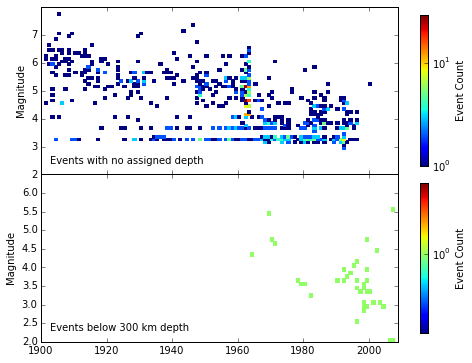

In [125]:
# assign layer ids and study contentious assignments
layer_id_array = np.full_like(catalogue.data['depth'], np.nan)
for _, layer in df_layers.iterrows():
    at_depth = ((catalogue.data['depth'] >= layer['zmin']) & 
                (catalogue.data['depth'] < layer['zmax']))
    layer_id_array[at_depth] = layer['id']

unassigned = catalogue.data['depth'] == -1
too_deep = catalogue.data['depth'] > layer_depths_km[-1]

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.subplots_adjust(hspace=0)

fig.sca(axes[0])
tb.annotate('Events with no assigned depth', loc='lower left')
catalogue_slice = deepcopy(catalogue)
catalogue_slice.select_catalogue_events(unassigned)
scp.plot_magnitude_time_density(catalogue_slice, 0.1, 1)

fig.sca(axes[1])
tb.annotate('Events below %g km depth' % (layer_depths_km[-1]), loc='lower left')
catalogue_slice = deepcopy(catalogue)
catalogue_slice.select_catalogue_events(too_deep)
scp.plot_magnitude_time_density(catalogue_slice, 0.1, 1)
plt.xlim(1900, 2009)


layer_id_array[unassigned] = 1
print 'Assigning %d/%d events without depths to layer 1' % (sum(unassigned), len(unassigned))
layer_id_array[too_deep] = 5
print 'Assigning %d/%d events below %g km depth to layer 5' % (sum(too_deep), len(too_deep), layer_depths_km[-1])
catalogue.data['layerid'] = layer_id_array

In [133]:
sort_mag = ['magnitude','year','month','day','hour','minute','second']
reverse_mag = [False, True, True, True, True, True, True]

print 'Bottom 5 events:'
display(pd.DataFrame(catalogue.data)[useful_keys].sort(columns=sort_mag).head(5))
print 'Top 10 events:'
display(pd.DataFrame(catalogue.data)[useful_keys].sort(columns=sort_mag, ascending=reverse_mag).head(10))

Bottom 5 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
22640,22693,ISC,Mainshock,1,2,0.39,2000,3,1,16,19,43.8,77.17,31.36,10,-1
37585,37638,ISC,Mainshock,1,2,0.4,2005,4,1,21,59,46.97,71.44,39.28,12.6,64
39728,39781,ISC,Mainshock,3,2,0.47,2005,9,29,20,42,28.28,72,37.76,164.4,1
40461,40514,ISC,Mainshock,2,2,0.4,2005,10,19,19,30,32.02,69.39,38.84,26.9,3
40777,40830,ISC,Mainshock,1,2,0.4,2005,11,12,22,1,34.87,70.08,38.97,9.3,64


Top 10 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
32844,32897,EHB,Mainshock,1,9.1,0.1,2004,12,26,0,58,52.28,95.86,3.277,21.5,0
32845,32898,GCMT,Mainshock,2,9.1,0.1,2004,12,26,1,1,9,94.26,3.09,28.6,-1
617,618,T2008a,Mainshock,2,8.6,0.2,1950,8,15,14,9,30,96.5,28.5,45,-1
37369,37422,ISC,Aftershock,2,8.6,0.1,2005,3,28,16,9,37.11,97.06,2.058,33.7,0
344,345,SG1980a,Mainshock,2,8.1,0.2,1934,1,15,8,43,-1,87.09,27.55,25,-1
550,551,ISC;B1992a,Mainshock,2,8.1,0.2,1945,11,27,21,56,50,63.48,25.15,25,-1
82,83,ISC,Mainshock,2,8,0.23,1912,5,23,2,24,6,97,21,35,-1
29,30,W2005a,Mainshock,1,7.8,0.2,1905,4,4,-1,50,-1,76.3,32.3,-1,-1
1288,1331,USGS,Mainshock,4,7.8,0.1,1965,3,14,15,53,7.64,70.72,36.4,207.8,3.1
26060,26113,EHB,Mainshock,1,7.8,0.1,2001,11,14,9,26,12.65,90.57,35.88,15,0


There are clearly 2 mainshocks in the top 10 magnitude events which are actually duplicates (not even aftershocks, but detectable as aftershocks).

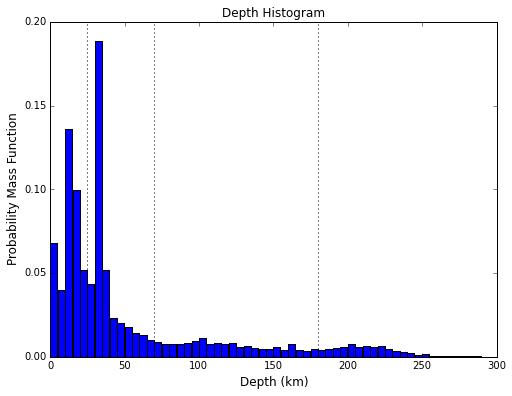

In [134]:
scp.plot_depth_histogram(catalogue, 5, normalisation=True)
plt.xlim(layer_depths_km[0], layer_depths_km[-1])
[plt.axvline(x, color='black', linestyle=':') for x in layer_depths_km];
plt.savefig('Depth histogram (catalogue).pdf', dpi=300, bbox_inches='tight')

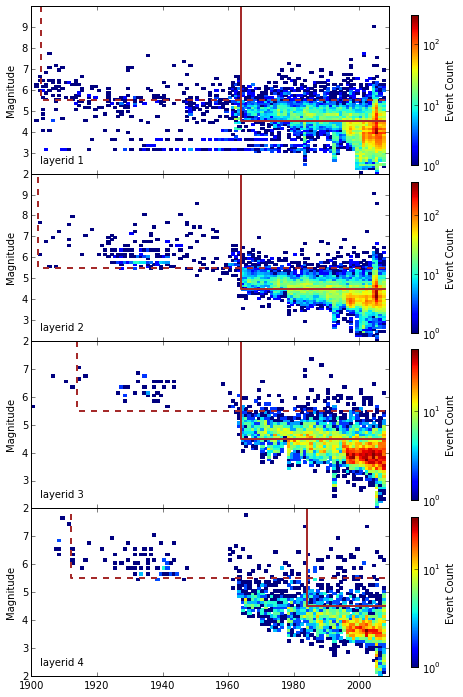

In [135]:
def plot_magnitude_time_density_slices(
        catalogue, completeness_tables, slice_key, slice_ids, mag_bin=0.1, time_bin=1):

    fig, axes = plt.subplots(len(slice_ids), 1, 
                             figsize=(8, 3*len(slice_ids)), sharex=True)
    fig.subplots_adjust(hspace=0)
    for ax, slice_id, completeness_tables_slice in zip(axes, slice_ids, completeness_tables):
        plt.sca(ax)
        tb.annotate('%s %d' % (slice_key, slice_id), loc='lower left')

        catalogue_slice = deepcopy(catalogue)
        in_slice = catalogue_slice.data[slice_key] == slice_id
        catalogue_slice.select_catalogue_events(in_slice)
        scp.plot_magnitude_time_density(
            catalogue_slice, mag_bin, time_bin, 
            completeness=completeness_tables_slice)
        
plot_magnitude_time_density_slices(catalogue, completeness_tables, 'layerid', layer_ids)
plt.xlim(1900, 2009)
plt.savefig('Magnitude time density (catalogue).pdf', dpi=300, bbox_inches='tight')

In [136]:
# implement Nath & Thingbaijam's declustering first
declustered = deepcopy(catalogue)
is_mainshock = [item == 'Mainshock' for item in declustered.data['comment']]
declustered.purge_catalogue(is_mainshock)
print 'Retained', declustered.get_number_events(), 'out of', catalogue.get_number_events(), 'events'

Retained 30881 out of 50279 events


In [137]:
print 'Bottom 5 events:'
display(pd.DataFrame(declustered.data)[useful_keys].sort(columns=sort_keys).head(5))
print 'Top 10 events:'
display(pd.DataFrame(declustered.data)[useful_keys].sort(columns=sort_keys, ascending=reverse_mag).head(10))

Bottom 5 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
16633,22693,ISC,Mainshock,1,2,0.39,2000,3,1,16,19,43.8,77.17,31.36,10,-1
24170,37638,ISC,Mainshock,1,2,0.4,2005,4,1,21,59,46.97,71.44,39.28,12.6,64
25127,39781,ISC,Mainshock,3,2,0.47,2005,9,29,20,42,28.28,72,37.76,164.4,1
25227,40514,ISC,Mainshock,2,2,0.4,2005,10,19,19,30,32.02,69.39,38.84,26.9,3
25362,40830,ISC,Mainshock,1,2,0.4,2005,11,12,22,1,34.87,70.08,38.97,9.3,64


Top 10 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
23656,32897,EHB,Mainshock,1,9.1,0.1,2004,12,26,0,58,52.28,95.86,3.277,21.5,0
23657,32898,GCMT,Mainshock,2,9.1,0.1,2004,12,26,1,1,9,94.26,3.09,28.6,-1
537,618,T2008a,Mainshock,2,8.6,0.2,1950,8,15,14,9,30,96.5,28.5,45,-1
306,345,SG1980a,Mainshock,2,8.1,0.2,1934,1,15,8,43,-1,87.09,27.55,25,-1
490,551,ISC;B1992a,Mainshock,2,8.1,0.2,1945,11,27,21,56,50,63.48,25.15,25,-1
75,83,ISC,Mainshock,2,8,0.23,1912,5,23,2,24,6,97,21,35,-1
28,30,W2005a,Mainshock,1,7.8,0.2,1905,4,4,-1,50,-1,76.3,32.3,-1,-1
1115,1331,USGS,Mainshock,4,7.8,0.1,1965,3,14,15,53,7.64,70.72,36.4,207.8,3.1
18652,26113,EHB,Mainshock,1,7.8,0.1,2001,11,14,9,26,12.65,90.57,35.88,15,0
18654,26115,GCMT,Mainshock,1,7.8,0.1,2001,11,14,9,43,12.27,92.41,35.6,15,-1


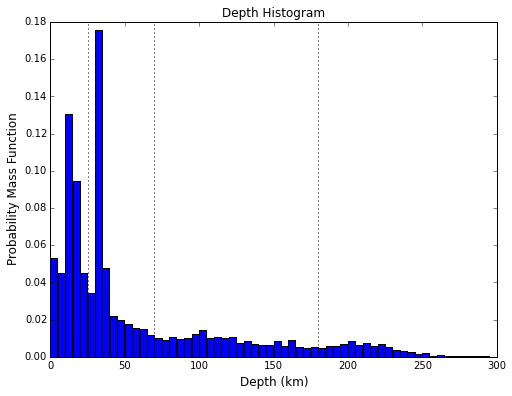

In [138]:
scp.plot_depth_histogram(declustered, 5, normalisation=True)
plt.xlim(layer_depths_km[0], layer_depths_km[-1])
[plt.axvline(x, color='black', linestyle=':') for x in layer_depths_km];
plt.savefig('Depth histogram (mainshocks).pdf', dpi=300, bbox_inches='tight')

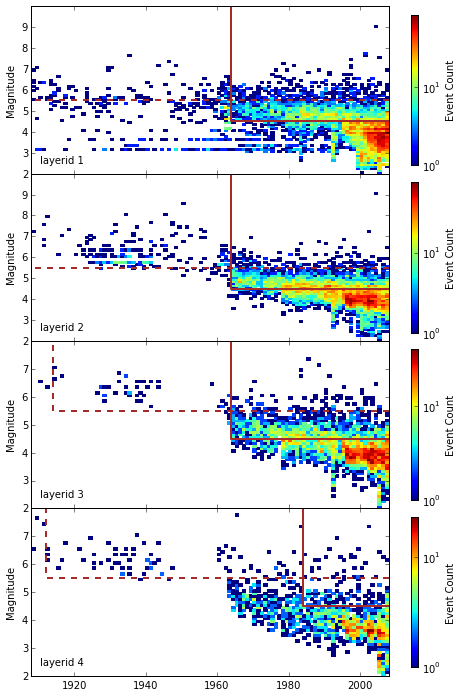

In [139]:
plot_magnitude_time_density_slices(declustered, completeness_tables, 'layerid', layer_ids)
plt.savefig('Magnitude time density (mainshocks).pdf', dpi=300, bbox_inches='tight')

In [140]:
# identify fore/aftershocks in the raw catalogue
declust_config_gk = {'time_distance_window': UhrhammerWindow(), 
                     'fs_time_prop': 1.0}
declustering_gk = GardnerKnopoffType1()

catalogue.data['cluster index'], catalogue.data['cluster flag'] = declustering_gk.decluster(
    catalogue, declust_config_gk)
print 'Identified %d foreshocks and %d aftershocks out of %d events' % (
    sum(catalogue.data['cluster flag']  == -1), 
    sum(catalogue.data['cluster flag']  == 1), 
    len(catalogue.data['cluster flag'] ))

Identified 5076 foreshocks and 17830 aftershocks out of 50279 events


In [142]:
# implement declustering from raw catalogue
declustered3 = deepcopy(catalogue)
declustered3.purge_catalogue(catalogue.data['cluster flag'] == 0)
print 'Retained', declustered2.get_number_events(), 'out of', declustered.get_number_events(), 'events'

Retained 24244 out of 30881 events


In [143]:
# identify fore/aftershocks among the mainshocks
declustered.data['cluster index'], declustered.data['cluster flag'] = declustering_gk.decluster(
    declustered, declust_config_gk)
print 'Identified an additional %d foreshocks and %d aftershocks out of %d' % (
    sum(declustered.data['cluster flag'] == -1), 
    sum(declustered.data['cluster flag'] == 1), 
    len(declustered.data['cluster flag']))

Identified an additional 3005 foreshocks and 2860 aftershocks out of 30881


In [144]:
# implement declustering from mainshocks
declustered2 = deepcopy(declustered)
declustered2.purge_catalogue(declustered.data['cluster flag'] == 0)
print 'Retained', declustered2.get_number_events(), 'out of', declustered.get_number_events(), 'events'

Retained 25016 out of 30881 events


In [147]:
print 'Bottom 5 events:'
display(pd.DataFrame(declustered2.data)[useful_keys].sort(columns=sort_keys).head(5))
print 'Top 10 events:'
display(pd.DataFrame(declustered2.data)[useful_keys].sort(columns=sort_keys, ascending=reverse_mag).head(10))

Bottom 5 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
13767,22693,ISC,Mainshock,1,2,0.39,2000,3,1,16,19,43.8,77.17,31.36,10,-1
19509,37638,ISC,Mainshock,1,2,0.4,2005,4,1,21,59,46.97,71.44,39.28,12.6,64
20320,39781,ISC,Mainshock,3,2,0.47,2005,9,29,20,42,28.28,72,37.76,164.4,1
20520,40830,ISC,Mainshock,1,2,0.4,2005,11,12,22,1,34.87,70.08,38.97,9.3,64
20555,40907,ISC,Mainshock,3,2,0.47,2005,11,19,23,2,46.85,70.46,37.07,149.5,1


Top 10 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
19110,32897,EHB,Mainshock,1,9.1,0.1,2004,12,26,0,58,52.28,95.86,3.277,21.5,0
492,618,T2008a,Mainshock,2,8.6,0.2,1950,8,15,14,9,30,96.5,28.5,45,-1
283,345,SG1980a,Mainshock,2,8.1,0.2,1934,1,15,8,43,-1,87.09,27.55,25,-1
451,551,ISC;B1992a,Mainshock,2,8.1,0.2,1945,11,27,21,56,50,63.48,25.15,25,-1
66,83,ISC,Mainshock,2,8,0.23,1912,5,23,2,24,6,97,21,35,-1
27,30,W2005a,Mainshock,1,7.8,0.2,1905,4,4,-1,50,-1,76.3,32.3,-1,-1
973,1331,USGS,Mainshock,4,7.8,0.1,1965,3,14,15,53,7.64,70.72,36.4,207.8,3.1
15350,26113,EHB,Mainshock,1,7.8,0.1,2001,11,14,9,26,12.65,90.57,35.88,15,0
5,6,UL2006a,Mainshock,2,7.7,-1,1902,8,22,3,-1,-1,76.2,39.88,30,-1
49,63,ISC,Mainshock,4,7.7,0.23,1909,7,7,21,37,50,70.5,36.5,230,-1


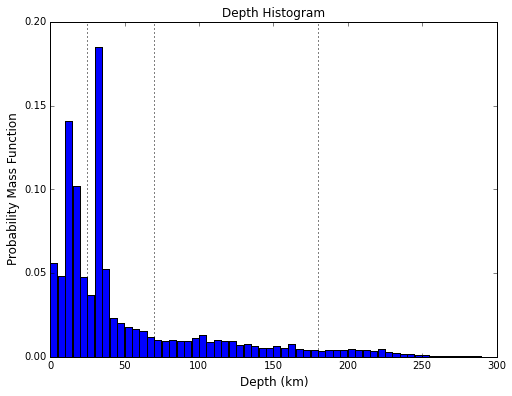

In [148]:
scp.plot_depth_histogram(declustered2, 5, normalisation=True)
plt.xlim(layer_depths_km[0], layer_depths_km[-1])
[plt.axvline(x, color='black', linestyle=':') for x in layer_depths_km];
plt.savefig('Depth histogram (declustered mainshocks).pdf', dpi=300, bbox_inches='tight')

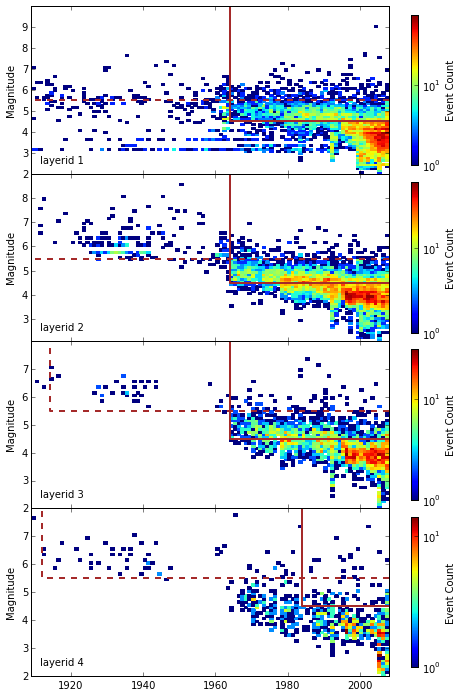

In [149]:
plot_magnitude_time_density_slices(declustered2, completeness_tables, 'layerid', layer_ids)
plt.savefig('Magnitude time density (declustered mainshocks).pdf', dpi=300, bbox_inches='tight')

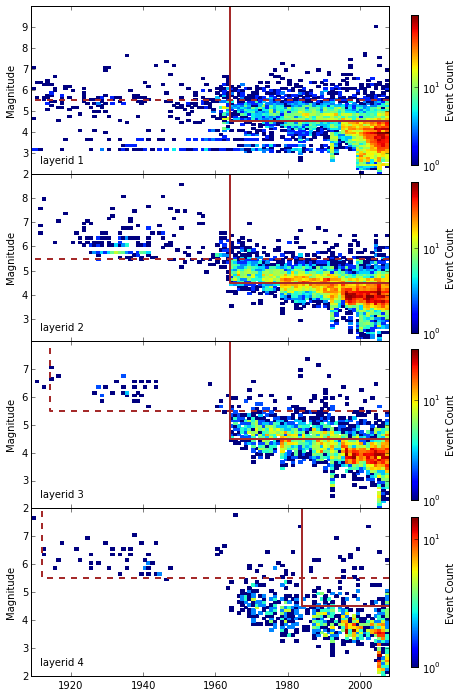

In [151]:
plot_magnitude_time_density_slices(declustered3, completeness_tables, 'layerid', layer_ids)
plt.savefig('Magnitude time density (declustered raw).pdf', dpi=300, bbox_inches='tight')

In [145]:
catalogues = [catalogue, declustered, declustered2, declustered3]
names = ['raw', 'mainshocks', 'declustered mainshocks', 'declustered raw']
year_bin = 1

df_poisson = pd.DataFrame()
for cat, name in zip(catalogues, names):
    for min_mag in np.arange(4, 7, 0.5):
        for layer_id in layer_ids + ['all']:
            for start_year in [1912, 1964, 1984, 1994]:
                df_catalogue = pd.DataFrame(cat.data)
                df_catalogue['t'] = cat.get_decimal_time()

                above_min = df_catalogue['magnitude'] >= min_mag
                in_years = df_catalogue['year'] >= start_year
                if layer_id == 'all':
                    in_layer = np.full_like(in_years, True)
                else:
                    in_layer = df_catalogue['layerid'] == layer_id
                bin_edges = np.arange(1964, cat.end_year + 1.5*year_bin, year_bin)

                t = df_catalogue[in_layer & in_years & above_min]['t']
                N = np.histogram(t, bin_edges)[0]
                if N.mean() < 1:
                    continue

                p_DT = poisson_test.dispersion(N)
                p_KSE = poisson_test.kolmogorov_smirnov(t, 'expon')
                p_combined = scs.combine_pvalues([p_KSE, p_DT])[1]
                result_series = pd.Series(
                    {'catalogue': name, 'min_mag': min_mag, 'start': start_year, 'layerid': layer_id, 'N': len(t),
                     'PD': p_DT, 'KSE': p_KSE, 'combined': p_combined})

                df_poisson = df_poisson.append(result_series, ignore_index=True)
df_poisson = df_poisson[['catalogue', 'min_mag', 'start', 'layerid', 'N', 'PD', 'KSE', 'combined']]

In [146]:
pd.options.display.float_format = lambda x: '%.4g' % x
display(df_poisson[df_poisson['combined'] > 1e-6].sort(columns='combined', ascending=False))

,catalogue,min_mag,start,layerid,N,PD,KSE,combined
168,mainshocks,5.5,1964,4,66,0.7396,0.8768,0.9294
167,mainshocks,5.5,1912,4,125,0.7396,0.5772,0.7903
256,declustered mainshocks,5.5,1964,3,91,0.4303,0.4277,0.4955
343,declustered raw,5.5,1964,3,94,0.2909,0.3013,0.3011
178,mainshocks,6,1964,2,59,0.08067,0.8724,0.2572
165,mainshocks,5.5,1964,3,127,0.3788,0.06445,0.1151
267,declustered mainshocks,6,1964,2,49,0.0262,0.7967,0.1016
255,declustered mainshocks,5.5,1912,3,132,0.4303,0.0392,0.08573
69,raw,5.5,1964,3,145,0.1587,0.08345,0.07049
72,raw,5.5,1964,4,86,0.0278,0.3462,0.05432


In [152]:
# compute smoothed-gridded seismicity - INTENSIVE!
grid_step = 0.2
grid_setup = [min_lon - grid_step/2., max_lon + grid_step/2., grid_step, 
              min_lat - grid_step/2., max_lat + grid_step/2., grid_step, 0., 1000., 1000.]  
smoother = SmoothedSeismicity(grid_setup, use_3d=False, bvalue=1.0)

for _, layer in df_layers.iterrows():
    for _, model in df_models.iterrows():
        kernel_config = {'Length_Limit': 3., 
                         'BandWidth': model['corr dist'], 
                         'increment': False}
        
        catalogue_layer = deepcopy(declustered)
        in_layer = catalogue_layer.data['layerid'] == layer['id']
        catalogue_layer.select_catalogue_events(in_layer)
        above_min = catalogue_layer.data['magnitude'] >= model['min mag']
        start_year = layer[str(model['min mag']) + ' start']
        end_year = layer[str(model['min mag']) + ' end']
        duration = end_year - start_year + 1
        print "Layer %d: %d events, %d with M >= %g or %.3g per year since %d" % (
            layer['id'], catalogue_layer.get_number_events(), 
            sum(above_min), model['min mag'], sum(above_min)/float(duration), start_year)
        
        # output file name
        large_csv = large_csv_template % (layer['id'], model['min mag'])                                      
        completeness_table = np.array([[start_year, model['min mag']]])
        output_data = smoother.run_analysis(
            catalogue_layer, kernel_config, completeness_table, 
            smoothing_kernel=IsotropicGaussian())
        print 'Writing output to "%s"' % large_csv
        smoother.write_to_csv(large_csv)
        print

Layer 1: 11877 events, 4396 with M >= 4.5 or 97.7 per year since 1964
Smoothing Total Rate Comparison - Observed: 87.9333, Smoothed: 88.2176
Writing output to "./Recomputed/smoothed_seismicity_layer1_mmin4.5.csv"

Layer 1: 11877 events, 681 with M >= 5.5 or 6.42 per year since 1903
Smoothing Total Rate Comparison - Observed: 5.08491, Smoothed: 5.10322
Writing output to "./Recomputed/smoothed_seismicity_layer1_mmin5.5.csv"

Layer 2: 10804 events, 4699 with M >= 4.5 or 104 per year since 1964
Smoothing Total Rate Comparison - Observed: 98.1111, Smoothed: 98.3145
Writing output to "./Recomputed/smoothed_seismicity_layer2_mmin4.5.csv"

Layer 2: 10804 events, 521 with M >= 5.5 or 4.87 per year since 1902
Smoothing Total Rate Comparison - Observed: 4.86916, Smoothed: 4.85694
Writing output to "./Recomputed/smoothed_seismicity_layer2_mmin5.5.csv"

Layer 3: 5763 events, 2048 with M >= 4.5 or 45.5 per year since 1964
Smoothing Total Rate Comparison - Observed: 44.2889, Smoothed: 44.3198
Writing

In [153]:
# do some filtering and reprocessing of smoothed seismicity
minimum = np.inf
maximum = 0
for min_mag in min_mags:
    for layer_id in layer_ids:
        
        large_csv = large_csv_template % (layer_id, min_mag)
        small_csv = small_csv_template % (min_mag, layer_id)
        old_txt = old_txt_template % (layer_id, min_mag)
        new_txt = new_txt_template % (layer_id, min_mag)
        
        # keep only points on the grid of the old model
        df_new = pd.read_csv(large_csv)
        df_old = pd.read_csv(old_txt)
        df_old.rename(columns={
                'latitude': 'Latitude', 'lat': 'Latitude', 
                'longitude': 'Longitude', 'lon': 'Longitude',
            }, inplace=True)
        df_new = pd.merge(df_old, df_new)
        
        # round the results
        df_new['Smoothed Rate'] = df_new['Smoothed Rate'].round(6)
        df_new = df_new[df_new['Smoothed Rate'] != 0]
        minimum = min(minimum, df_new['Smoothed Rate'].min())
        maximum = max(maximum, df_new['Smoothed Rate'].max())
        
        # get rid of uninteresting columns
        df_new.drop(['Depth', 'b-value'], axis=1, inplace=True)
        df_new.to_csv(small_csv, index=False)
        
        # also write new dataset in old format
        rename_cols = {'Smoothed Rate': 'nu', 'Latitude':'lat', 'Longitude': 'lon'}
        df_new.rename(columns=rename_cols, inplace=True)
        df_new = df_new[['lon', 'lat', 'nu']]
        df_new.to_csv(new_txt, index=False, sep=',', float_format='%g')
                      
limits = tb.stdval((minimum, maximum), 3)
print "limits", limits

limits [  1.00000000e-06   2.00000000e-01]


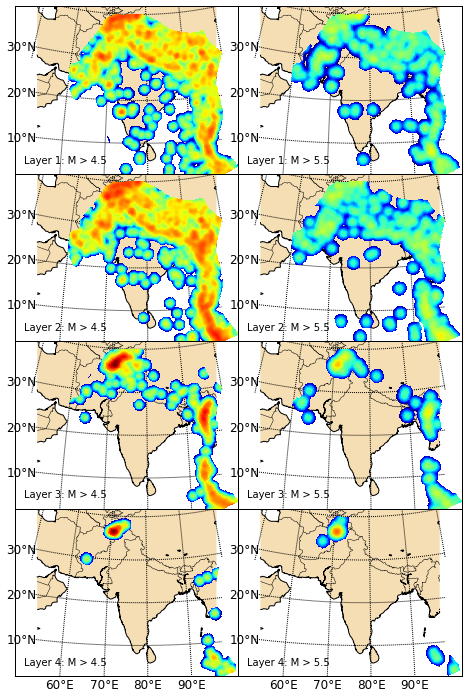

In [154]:
point_size = (grid_step/0.2)**2
map_config = {'min_lon': min_lon, 'max_lon': max_lon, 'min_lat': min_lat, 'max_lat': max_lat, 
              'parallel_meridian_spacing': 10, 'resolution':'l'}

fig, axes = plt.subplots(len(layer_ids), len(min_mags), figsize=(8,12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
for i, layer_id in enumerate(layer_ids):
    for j, min_mag in enumerate(min_mags):
        plt.sca(axes[i, j])
        tb.annotate('Layer %d: M > %g' % (layer_id, min_mag), 'lower left')

        small_csv = small_csv_template % (min_mag, layer_id)
        df = pd.read_csv(small_csv)
        basemap = HMTKBaseMap(map_config, None)
        basemap.add_colour_scaled_points(
            df['Longitude'].values, df['Latitude'].values, 
            df['Smoothed Rate'].values, size=point_size, alpha=1,
            norm=LogNorm(limits[0], limits[1]), overlay=True, add_colorbar=False)
        
fig.savefig('SmoothedRecalculated.png', dpi=300, bbox_inches='tight')

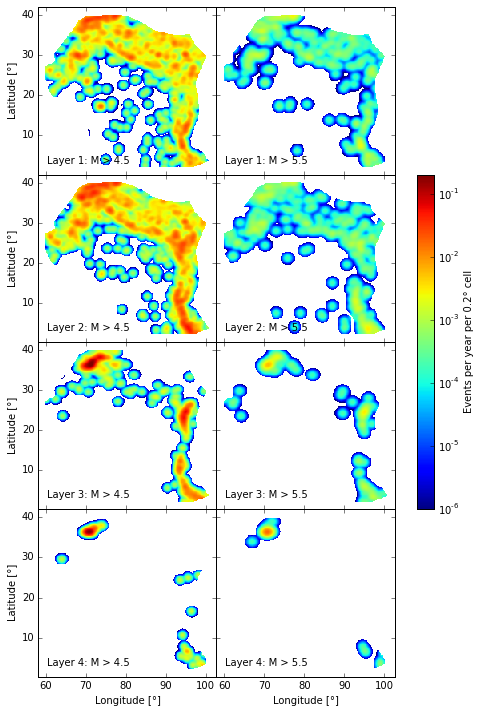

In [155]:
fig, axes = plt.subplots(len(layer_ids), len(min_mags), 
                         figsize=(8,12), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for i, layer_id in enumerate(layer_ids):
    for j, min_mag in enumerate(min_mags):
        plt.sca(axes[i, j])
        tb.annotate('Layer %d: M > %g' % (layer_id, min_mag), 'lower left')

        small_csv = small_csv_template % (min_mag, layer_id)

        df = pd.read_csv(small_csv)
        im = plt.scatter(df['Longitude'].values, df['Latitude'].values, 
                    c=df['Smoothed Rate'].values, s=point_size, marker='s', edgecolor='none', 
                    cmap='jet', norm=LogNorm(limits[0], limits[1]))
plt.gca().set_aspect('equal')
plt.autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, 
             label=u'Events per year per %g° cell' % grid_step)
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]

fig.savefig('SmoothedRecalculatedNoMap.pdf', dpi=300, bbox_inches='tight')

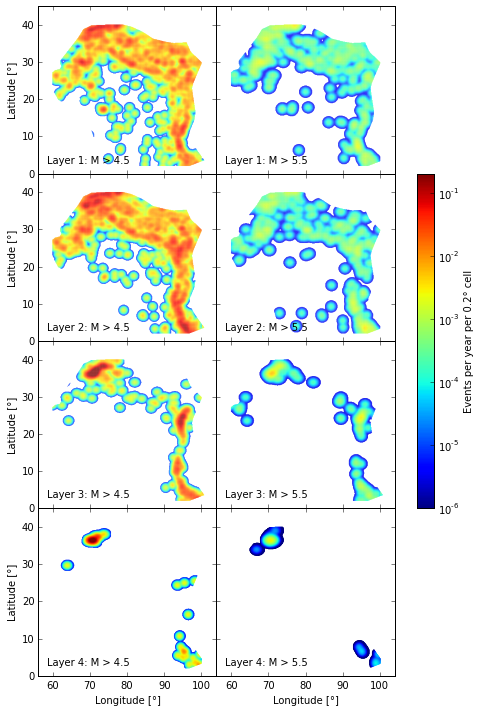

In [156]:
fig, axes = plt.subplots(len(layer_ids), len(min_mags), 
                         figsize=(8,12), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for i, layer in df_layers.iterrows():
    for j, model in df_models.iterrows():
        plt.sca(axes[i, j])
        tb.annotate('Layer %d: M > %g' % (layer['id'], model['min mag']), 'lower left')

        old_txt = old_txt_template % (layer['id'], model['min mag'])
         
        df = pd.read_csv(old_txt)
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude'}, inplace=True)
        
        nu_mag = [item for item in df.keys() if 'nu' in item][0]
        start_year = layer[str(model['min mag']) + ' start']
        end_year = layer[str(model['min mag']) + ' end']
        old_step = np.mean(np.diff(sorted(list(set(df['latitude'])))))
        
        # convert from count to rate and from old grid to current
        equivalent_rate = df[nu_mag].values*(((grid_step/old_step)**2)/
                                             (end_year - start_year + 1))
        point_size = (old_step/0.2)**2
        im = plt.scatter(df['longitude'].values, df['latitude'].values, 
                    c=equivalent_rate, s=point_size, edgecolor='none',
                    cmap='jet', norm=LogNorm(limits[0], limits[1]))
        
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, 
             label=u'Events per year per %g° cell' % grid_step)
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]

fig.savefig('SmoothedThinbaigjamNoMap.pdf', dpi=300, bbox_inches='tight')

In [157]:
c = 85  # km correlation distance
delta = 0.1  # grid spacing
span = 2.5  # test grid span
lon = 80  # degrees
lat = 20  # degrees
point = geo.Point(lon, lat)
lon_list = np.arange(lon - span, lon + span + delta/2, delta)
lat_list = np.arange(lat - span, lat + span + delta/2, delta)
lon_limits = (lon - span - delta/2, lon + span + delta/2)
lat_limits = (lat - span - delta/2, lat + span + delta/2)
lon_mesh, lat_mesh = np.meshgrid(lon_list, lat_list)
mesh = geo.RectangularMesh(lon_mesh, lat_mesh)
distances = point.distance_to_mesh(mesh)
i_mid = int(span/delta)
span_km = (distances[i_mid,:].max(), distances[:,i_mid].max())
print('Grid extents %g and %g km' % span_km)
print('Must be at least 3x correlation distance or %g km' % (3*c))
if all(np.array(span_km) > 3*c):
    print 'OK!'
else:
    print 'Problem!'
weights = np.exp(-(distances/c)**2) * (distances < 3*c)
print(u'For correlation distance %g km and grid spacing %g°' % (c, delta))
print('the unnormalized weights sum to %g.' % weights.sum())

Grid extents 261.22 and 277.987 km
Must be at least 3x correlation distance or 255 km
OK!
For correlation distance 85 km and grid spacing 0.1°
the unnormalized weights sum to 195.338.


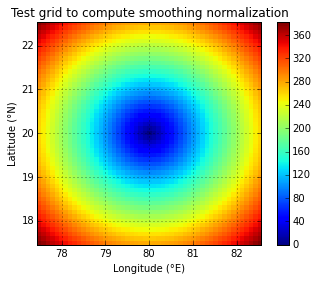

In [158]:
plt.imshow(distances, origin='lower', aspect='equal', 
           interpolation='nearest', 
           extent=lon_limits + lat_limits)
plt.title('Test grid to compute smoothing normalization')
plt.xlabel(u'Longitude (°E)')
plt.ylabel(u'Latitude (°N)')
plt.grid()
plt.colorbar();

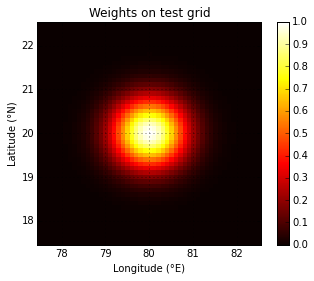

In [159]:
plt.imshow(weights, cmap='hot', origin='lower', aspect='equal', 
           interpolation='nearest', 
           extent=lon_limits + lat_limits)
plt.title('Weights on test grid')
plt.xlabel(u'Longitude (°E)')
plt.ylabel(u'Latitude (°N)')
plt.grid()
plt.colorbar();